# Filters with sensitivity to various predefined parameters

This notebook shows the use of several filters and their sensitivity to predefined parameters.

Used filters are

    1) Moving average (sensitivity to MA lenght)
    2) Hodrick-Prescott filter (sensitivity to Lambda)
    3) Kalman filter (sensitivity to predefined transition covariance)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date, timedelta

from matplotlib import pyplot

import statsmodels.api as sm
from pykalman import KalmanFilter

In [2]:
start_date_data = (date.today()-timedelta(days=(252*3))).isoformat() #Download data for last 3 trading years

#Charting starts after half a year, as moving averages have the first values n/a 
#Also the Kalman filter needs the first data to learn
start_date_chart = (date.today()-timedelta(days=(252*2.5))).isoformat() 

brent=yf.download('BZ=F',start=start_date_data,time_interval='monthly')  #Download from yfinance
    
alpha=0.2   #Visual parameter for charting

[*********************100%***********************]  1 of 1 completed


### Moving average

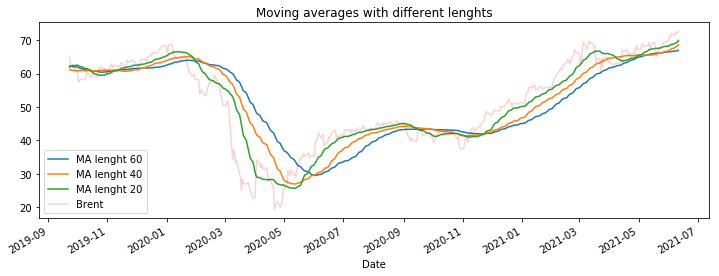

In [3]:
ma_lenghts=np.array([60,40,20])   #Various lenghts of moving average

for ma_lenght in ma_lenghts:
    brent[ma_lenght]=brent['Close'].rolling(ma_lenght).mean()
    
    
    brent[ma_lenght][start_date_chart:].plot(label=f"MA lenght {ma_lenght}",legend=True)
    
brent['Close'][start_date_chart:].plot(figsize=(12,4),alpha=alpha,label="Brent",
                                       legend=True,title="Moving averages with different lenghts")
pyplot.show()

### Hodrick-Prescott filter

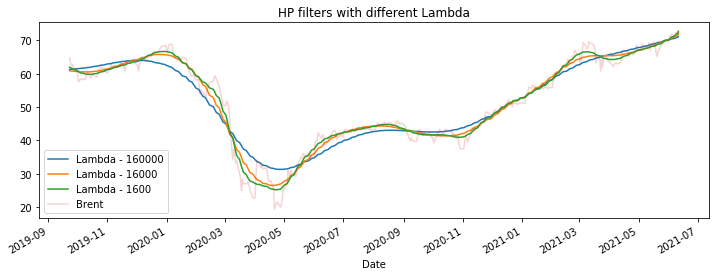

In [4]:
hp_lambda=np.array([160000,16000,1600])   #Various lambdas

for Lambda in hp_lambda:
    hp_brent_cycle, hp_brent_trend = sm.tsa.filters.hpfilter(brent['Close'], Lambda)
    
    
    hp_brent_trend[start_date_chart:].plot(label=f"Lambda - {Lambda}",legend=True)
    
brent['Close'][start_date_chart:].plot(figsize=(12,4),alpha=alpha,label="Brent",
                                       legend=True,title="HP filters with different Lambda")
pyplot.show()

### Kalman filter

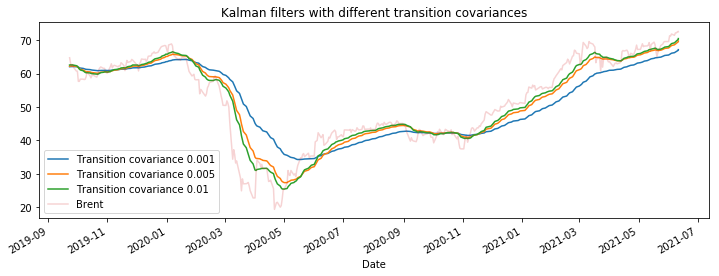

In [5]:
transition_covariances=np.array([0.001,0.005,0.01])  #Various transition covariances

for transition_covariance in transition_covariances:
    kf=KalmanFilter(transition_matrices=[1],
               observation_matrices=[1],
               initial_state_mean=0,
               initial_state_covariance=1,
               observation_covariance=1,
               transition_covariance=transition_covariance) 

    state_means,_=kf.filter(brent['Close'].values)

    state_means=pd.Series(state_means.flatten(),index=brent['Close'].index)
    
    state_means[start_date_chart:].plot(label=f"Transition covariance {transition_covariance}", legend=True)

    
    
brent['Close'][start_date_chart:].plot(figsize=(12,4),alpha=alpha,label="Brent",legend=True,
                                       title="Kalman filters with different transition covariances")
pyplot.show()

### All filters together

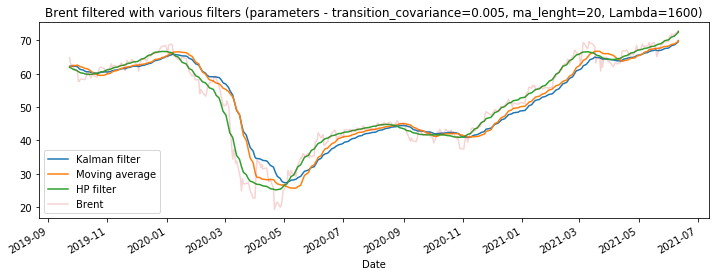

In [6]:
#Selected parameters for combined chart 
ma_level=20
Lambda=1600
transition_covariance=0.005


#Moving average
brent_ma=brent['Close'].rolling(ma_level).mean() 

#Hodrick-Prescott filter
hp_brent_cycle, hp_brent_trend = sm.tsa.filters.hpfilter(brent['Close'], Lambda)   

#Kalman filter
kf=KalmanFilter(transition_matrices=[1],
               observation_matrices=[1],
               initial_state_mean=0,
               initial_state_covariance=1,
               observation_covariance=1,
               transition_covariance=transition_covariance)

state_means,_=kf.filter(brent['Close'].values)
state_means=pd.Series(state_means.flatten(),index=brent['Close'].index)

#Plotting part
state_means[start_date_chart:].plot(label="Kalman filter", legend=True)
brent_ma[start_date_chart:].plot(label="Moving average",legend=True)
hp_brent_trend[start_date_chart:].plot(label="HP filter",legend=True)
brent['Close'][start_date_chart:].plot(figsize=(12,4),alpha=alpha,label="Brent",legend=True,
                                       title=f"Brent filtered with various filters (parameters - transition_covariance={transition_covariance}, ma_lenght={ma_level}, Lambda={Lambda})")
pyplot.show()

This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services. Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, author has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, freely availible at the time of publication. Author makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.